<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/04_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prompt Chaining


---


Multiple prompts are sequenced togethor to guide a model through complex task or reasoning

In [119]:
!pip install langchain langgraph langchain_groq pydantic

In [120]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_key = userdata.get('groq_key')

llm = ChatGroq(api_key=groq_key, model="meta-llama/llama-4-scout-17b-16e-instruct",)

In [121]:
llm.invoke("Hello")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.057161739, 'prompt_time': 0.002457306, 'queue_time': 0.19518105900000002, 'total_time': 0.059619045}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f52f6061-33f6-4b0a-bf70-f4817c1afef1-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [122]:
from typing_extensions import Annotated
from langgraph.graph import StateGraph,START,END
from IPython.display import display, Image
from pydantic import BaseModel

In [123]:
from typing import Optional
class State(BaseModel):
  topic:str
  story:Optional[str] =''
  improved_story:Optional[str] =''
  final_story:Optional[str] = ''


In [124]:
def generate_story(state:State) -> State:
  msg = llm.invoke(f"write a one sentence story premise about {state.topic}")
  state.story = msg.content
  return state

In [125]:
def check_conflit(state:State) -> str:
    if "?" in state.story or "!" in state.story :
      return "Fail"
    return "Pass"

In [126]:
def improved_story(state:State) -> State:
  msg = llm.invoke(f"Enhance this store with Vivid details : {state.story}")
  state.improved_story = msg.content
  return state


In [127]:
def polished_Story(state:State) -> State:
  msg = llm.invoke(f"Add an unexpected twist to this story premise: {state.improved_story}")
  state.final_story = msg.content
  return state

In [128]:
graph = StateGraph(State)

In [129]:
graph.add_node("generate",generate_story)
graph.add_node("improve",improved_story)
graph.add_node("polish",polished_Story)

In [130]:
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflit,{"Pass":"improve","Fail":"generate"})
graph.add_edge("generate","improve")
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

In [131]:
graph_builder = graph.compile()

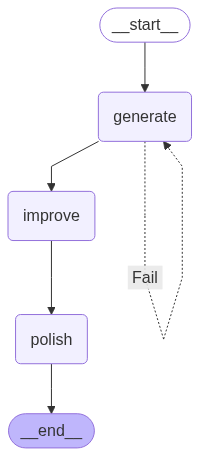

In [132]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [133]:
state = State(topic="The Great Gatsby")
res=graph_builder.invoke(state)

In [134]:
res['final_story']

'**Step into the Roaring Twenties: A World of Enchantment and Tragedy... and Interdimensional Portals**\n\nImagine yourself transported to the vibrant streets of Long Island\'s West Egg, where the jazz era comes alive with the sound of speakeasies and flappers dancing the Charleston. It\'s here that Nick Carraway, a young and ambitious bond salesman from the Midwest, finds himself enthralled by the mystique of his neighbor, Jay Gatsby. But little does Nick know, Gatsby\'s mansion is not just a grand estate – it\'s a nexus point for interdimensional travel.\n\nAs Nick gazes out at the glittering lights of Gatsby\'s mansion, he begins to notice strange, unexplained occurrences. The jazz music seems to be coming from multiple directions at once, and the champagne glasses clinking in the background seem to be refilling themselves. The air is alive with the sweet scent of blooming flowers, but also a faint hint of ozone and burning fuel. The soft glow of candelabras and string lights illumi

Parallezation



---

We can execute the code parallelly

In [135]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
character_prompt = PromptTemplate.from_template("create three character with supier hero abilities reurn only their names")
premise_prompt = PromptTemplate.from_template("write a one sentence about the premise where the story take place")
villan_prompt = PromptTemplate.from_template("write a one sentence about the villan with some supier powers")
story_prompt = PromptTemplate.from_template("write a story where the following are the lead charcther with their power:{character} and the story happens at premise :{premise} and villan of the story is :{villan} ")

In [136]:
class ParallelState(BaseModel):
  character:Optional[str] =''
  premise:Optional[str]=''
  villan:Optional[str]=''
  story:Optional[str]=''

In [137]:
def get_character(state:ParallelState) -> State:
  msg = character_prompt | llm
  return {"character": msg.invoke({}).content}

def get_premise(state:ParallelState) -> State:
    msg = premise_prompt | llm
    return {"premise": msg.invoke({}).content}

def get_villan(state:ParallelState) -> State:
    msg = villan_prompt | llm
    return {"villan": msg.invoke({}).content}

In [138]:
def combibe_story(state:ParallelState) -> State:
  msg = story_prompt | llm
  res = msg.invoke({"character":state.character,"premise":state.premise,"villan":state.villan}).content
  return {"story": res}

In [139]:
parallel_graph = StateGraph(ParallelState)
parallel_graph.add_node("get_character",get_character)
parallel_graph.add_node("get_premise",get_premise)
parallel_graph.add_node("get_villan",get_villan)
parallel_graph.add_node("combibe_story",combibe_story)

parallel_graph.add_edge(START,"get_character")
parallel_graph.add_edge(START,"get_premise")
parallel_graph.add_edge(START,"get_villan")
parallel_graph.add_edge("get_character","combibe_story")
parallel_graph.add_edge("get_premise","combibe_story")
parallel_graph.add_edge("get_villan","combibe_story")

parallel_graph.add_edge("combibe_story",END)

parallel_graph_builder = parallel_graph.compile()

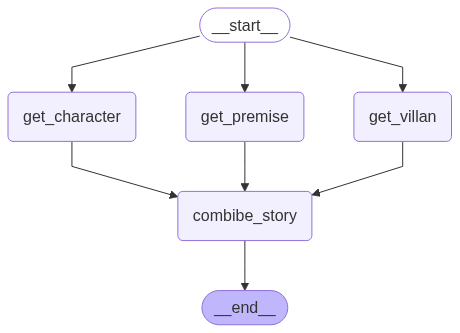

In [140]:
display(Image(parallel_graph_builder.get_graph().draw_mermaid_png()))

In [141]:
parallel_state = ParallelState()
parallel_res = parallel_graph_builder.invoke(parallel_state)


In [151]:
res_list = list(filter(lambda x: x.strip() != '', parallel_res['story'].split('\n')))
res_list

["Let's create a story with the given characters and premise.",
 'In the mystical realm of Aethoria, where the skies were painted with colors of sapphire and amethyst, and ancient magic dwelled within the whispers of the wind, three young individuals with extraordinary abilities were about to embark on a perilous quest.',
 "**Apex**, a skilled warrior with superhuman strength and agility, was training in the heart of the Dragon's Spine mountains. His powers allowed him to leap great distances and strike with precision, making him a formidable opponent in combat.",
 '**Starlight**, a celestial mage with the ability to control and manipulate light, was studying the ancient lore of Aethoria in the grand library of the Crystal Spire. Her powers enabled her to create blindingly bright illusions, heal wounds with gentle rays of light, and even fly by propelling herself with her luminescent magic.',
 "**Quantum**, a brilliant inventor with the ability to manipulate matter and energy, was tink